<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><div align="center">This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.</div>

----

# Preparing the environment

## Graphics and plotting

The following block of code initializes the Python plotting library [matplotlib](http://matplotlib.org/gallery.html) and configures it to show figures embedded in the notebook (as opposed to opening a new window for each figure):

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

The Seaborn library provides easy-to-use plotting functions for common plot types, and better default visual styles.

In [2]:
import seaborn as sea

Set the default size and style of the plot.  (Plots are styled to [look like R's `ggplot`](http://tonysyu.github.io/mpltools/auto_examples/style/plot_ggplot.html) library.)

In [3]:
matplotlib.rcParams['figure.figsize'] = (10, 7)

sea.set_style('dark')

Also make the NumPy library available (without it, some features of Matplotlib and -especially- Seaborn) will *not* work:

In [4]:
import numpy as np

A "colormap" is a mapping from a range of numbers onto a set of colors.  The `cmocean` Python package contains some predefined colormaps for plotting geographical data.  We single out the "thermal" colormap for plotting temperature data.

In [5]:
import cmocean
cm_thermal = cmocean.cm.thermal

## SQL database connection

The ESC403 cluster comes preinstalled with [Catherine Devlin's `%sql`-magic for IPython][1]; this allows you to run SQL queries from the IPython notebook, and intermix them with Python code.

[1]: https://github.com/catherinedevlin/ipython-sql

Before we can use the `%sql` syntax, two steps must be taken:

* Load the IPython-SQL bridge code

In [6]:
%load_ext sql

* Connect to an actual database; this must be the first `%sql` statement (the `rmurri@/equidistantpoints` syntax means "connect to the PostGreSQL DB named `equidistantpoints` running on *this* host as user `rmurri`" -- of course change `rmurri` to *your* user name):

In [7]:
%sql postgresql://rmurri@/equidistantpoints

u'Connected: rmurri@equidistantpoints'

This database contains the [Equidistant Geographic Grid Points and Modern Climate](http://mypage.iu.edu/~pdpolly/Data.html) dataset (this the "extended North American data" in the words of the source website), see the [original publication](http://mypage.iu.edu/~pdpolly/Data.html) for details.

We are going to use only the "temperature" table in the following. (But feel free to experiment with the others!)

In [8]:
%sql select * from natempwilmott limit 3;

3 rows affected.


id,longitude,latitude,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,ann
6,-79.46900,82.81348,-35.00000,-37.00000,-33.00000,-24.90000,-10.00000,0.30000,3.30000,1.40000,-9.00000,-20.70000,-28.80000,-32.50000,-18.90000
7,-75.87860,82.81348,-35.00000,-37.10000,-32.80000,-24.70000,-9.90000,0.10000,3.30000,1.40000,-9.20000,-20.90000,-28.80000,-32.30000,-18.80000
8,-72.28820,82.81348,-34.90000,-36.90000,-32.70000,-24.60000,-9.90000,-0.10000,3.20000,1.30000,-9.50000,-20.90000,-28.80000,-32.00000,-18.80000


----

# Interactive plotting

Jupyter/IPython provides facilities for making interactive visualizations in the notebook.

The general schema for making an interactive visualization is:

1. Make a function that takes the interactively-settable parameters as arguments, and returns a "plot" (or any other object that can be shown in the notebook).
2. Decorate this function with the `@interact` annotation, providing initial values for all interactively-settable parameters.

All relevant code lives in Python module `ipywidgets`:

In [9]:
from ipywidgets import interact, FloatSlider, Select, Dropdown

The following example shows how to create an interactive sine wave plot (see [here](http://earthpy.org/pyncview_pm.html)).  Note how IPython automatically detects the parameter type and uses a slider to set floating-point values and a text-box for the `color` parameter:

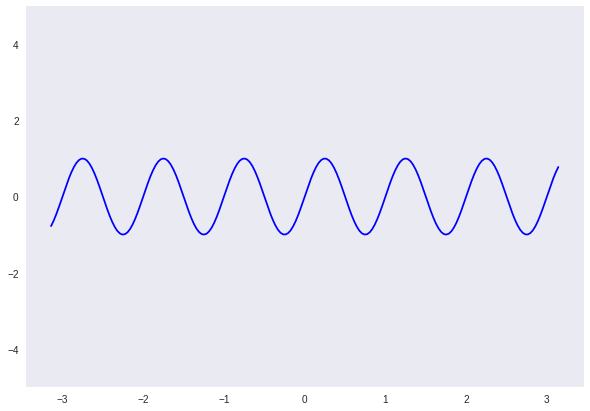

In [10]:
@interact(freq=1.0, amp=1.0, color='blue')
def wave(freq, amp, color):
    xs = np.linspace(-np.pi, +np.pi, 200)
    ys = np.sin(2*np.pi*freq*xs) * amp
    ax = plt.gca()
    ax.plot(xs, ys, color=color)
    ax.set_ylim([-5., +5.])
    return ax

However, with auto-detection we cannot constrain the input values: e.g., we cannot set the valid range of inputs, nor restrict the color selection.  It is possible to explicitly instanciate the widget to use for setting a parameter from a [large Widget list](http://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html).

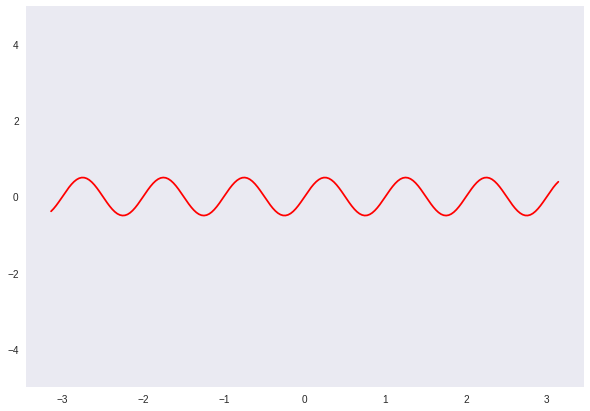

In [11]:
@interact(freq=1.0, 
          amp=FloatSlider(min=0.5, max=5.0, step=0.1), 
          color=Select(options=['red', 'green', 'blue'], description='color'))
def wave(freq, amp, color):
    xs = np.linspace(-np.pi, +np.pi, 200)
    ys = np.sin(2*np.pi*freq*xs) * amp
    ax = plt.gca()
    ax.plot(xs, ys, color=color)
    ax.set_ylim([-5., +5.])
    return ax

Using slider widgets often results in screen flickering (redrawing the plot is slower than just moving a slide).  The `continuous_update=False` argument can be added to the slider to only re-paint upon mouse button release.

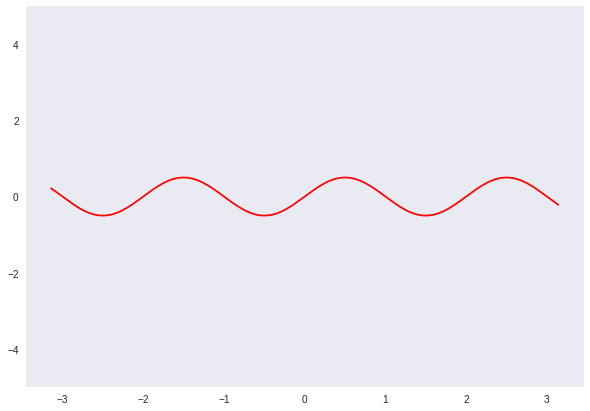

In [12]:
@interact(freq=FloatSlider(min=0.5, max=5.0, step=0.1, continuous_update=False), 
          amp=FloatSlider(min=0.5, max=5.0, step=0.1, continuous_update=False), 
          color=Select(options=['red', 'green', 'blue'], description='color'))
def wave(freq, amp, color):
    xs = np.linspace(-np.pi, +np.pi, 200)
    ys = np.sin(2*np.pi*freq*xs) * amp
    ax = plt.gca()
    ax.plot(xs, ys, color=color)
    ax.set_ylim([-5., +5.])
    return ax

----

## 1. Make an interactive plot of the earth surface: viewport is selected using sliders

For the making plots of the Earth surface, we need to import the CartoPy library and relevant submodules.

In [13]:
import cartopy
import cartopy.crs

# Create a Cartopy crs for plain  lat-lon projections.
plain_crs = cartopy.crs.PlateCarree()

The following `worldplot` function displays a rectangle of a "plate carree" projection, with longitude ranging from `e` to `w`, and latitude ranging from `b` to `t`.

In [14]:
def worldplot(e,w,n,s):
    """
    Plot a rectangular map of the world, 
    ranging in longitude from `e` to `w`, and in latitude from `s` to `n`.
    """
    ax = plt.subplot(111, projection=plain_crs)
    ax.set_extent((e, w, n, s), crs=plain_crs)
    ax.gridlines(color='lightgrey', linestyle='-')
    ax.coastlines()
    return ax

The `interact` function can be called explicitly (i.e., not in decorator form).  In this case, the function to be called interactively is passed in as first argument.

/opt/anaconda2/lib/python2.7/site-packages/matplotlib/ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


<function __main__.worldplot>

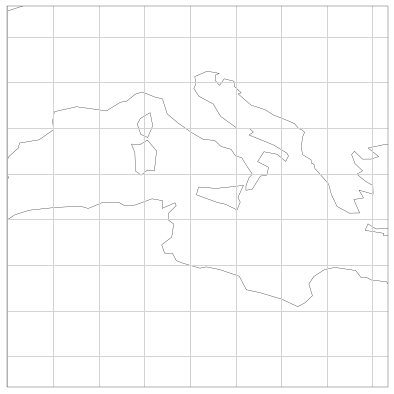

In [15]:
interact(worldplot, 
         e=FloatSlider(value=0,   min=-180.0, max=180.0, step=1.0, continuous_update=False),
         w=FloatSlider(value=25,  min=-180.0, max=180.0, step=1.0, continuous_update=False),
         n=FloatSlider(value=+50, min=-90.0,  max=90.0,  step=1.0, continuous_update=False),
         s=FloatSlider(value=+25, min=-90.0,  max=90.0,  step=1.0, continuous_update=False))

## 2. Make an interactive plot of average temperatures in NA: month should be selectable

Let us set up a few utility functions first.

#### 1. A function to create and return a plot of North America:

In [16]:
def plot_north_america():
    ax = plt.subplot(111, projection=plain_crs)
    ax.set_extent((-180, -40, 10, 80), crs=plain_crs)
    ax.gridlines(color='lightgrey', linestyle='-')
    ax.coastlines()
    return ax

#### 2. Fetch the data from SQL

In [17]:
data = %sql SELECT * FROM natempwilmott 

8509 rows affected.


In [18]:
data[:2]

[(6, Decimal('-79.46900'), Decimal('82.81348'), Decimal('-35.00000'), Decimal('-37.00000'), Decimal('-33.00000'), Decimal('-24.90000'), Decimal('-10.00000'), Decimal('0.30000'), Decimal('3.30000'), Decimal('1.40000'), Decimal('-9.00000'), Decimal('-20.70000'), Decimal('-28.80000'), Decimal('-32.50000'), Decimal('-18.90000')),
 (7, Decimal('-75.87860'), Decimal('82.81348'), Decimal('-35.00000'), Decimal('-37.10000'), Decimal('-32.80000'), Decimal('-24.70000'), Decimal('-9.90000'), Decimal('0.10000'), Decimal('3.30000'), Decimal('1.40000'), Decimal('-9.20000'), Decimal('-20.90000'), Decimal('-28.80000'), Decimal('-32.30000'), Decimal('-18.80000'))]

A direct SQL query shows the order and names of columns.

In [19]:
%sql SELECT * FROM natempwilmott LIMIT 3;

3 rows affected.


id,longitude,latitude,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,ann
6,-79.46900,82.81348,-35.00000,-37.00000,-33.00000,-24.90000,-10.00000,0.30000,3.30000,1.40000,-9.00000,-20.70000,-28.80000,-32.50000,-18.90000
7,-75.87860,82.81348,-35.00000,-37.10000,-32.80000,-24.70000,-9.90000,0.10000,3.30000,1.40000,-9.20000,-20.90000,-28.80000,-32.30000,-18.80000
8,-72.28820,82.81348,-34.90000,-36.90000,-32.70000,-24.60000,-9.90000,-0.10000,3.20000,1.30000,-9.50000,-20.90000,-28.80000,-32.00000,-18.80000


#### 3. Create sorted arrays of longitude/latitude values

In [20]:
longitude = np.array(sorted(set(row[1] for row in data)), dtype=np.float)

In [21]:
latitude = np.array(sorted(set(row[2] for row in data)), dtype=np.float)

In [22]:
longitude[:3], latitude[:3]

(array([-170.94039, -166.87923, -166.26217]),
 array([ 7.35503,  7.80419,  8.25335]))

#### 4. Create a 3D matrix to hold temperature values

Once a month is chosen, we need a *masked* 2D matrix to hold the temperature values for the plot.  So we shall store the temperature values in an array of 2D matrices, coded by month number (0=Jan., 1=Feb., ..., 12=All year).  This takes then the form of a 3D NumPy array, with one coordinate taking the discrete values 0..12 and the other two varying in the `longitude` and `latitude` arrays.

In [23]:
n_lon = len(longitude)
n_lat = len(latitude)
n_col = len(data[0]) - len(['id', 'longitude', 'latitude'])

To form a masked array we need to build the data and mask parts separately.

In [24]:
temp3d_data = np.empty([n_col, n_lon, n_lat], dtype=np.float)
temp3d_mask = np.full(temp3d_data.shape, True,  dtype=np.bool)

In [25]:
%%time

lon_to_index = { value:idx for idx, value in enumerate(longitude) }
lat_to_index = { value:idx for idx, value in enumerate(latitude) }

for row in data:
    x = float(row[1])
    y = float(row[2])
    i = lon_to_index[x]
    j = lat_to_index[y]
    for n, value in enumerate(row[3:]):
        temp3d_data[n, i, j] = float(value)
        temp3d_mask[n, i, j] = False

CPU times: user 334 ms, sys: 36.5 ms, total: 371 ms
Wall time: 374 ms


In [26]:
temp3d = np.ma.array(temp3d_data, mask=temp3d_mask)

#### 5. Plotting time!

Let us define a function to do the plotting.  Note that the only parameter `period` is a number (integer in range 0..12 inclusive), which selects the column from the `temp` array with the data to plot: 0=Jan., 1=Feb., ..., 12=Year.

In [27]:
def temp_plot(period):
    ax = plot_north_america()
    temp2d = temp3d[period, :, :]
    ax.pcolormesh(longitude, latitude, temp2d.T, transform=plain_crs, cmap=cm_thermal)
    return ax

Now use the NA temperature plotting function interactively.  Note that IPython automatically selects the `Dropdown` widget when presented with `dict`-data.

<function __main__.temp_plot>

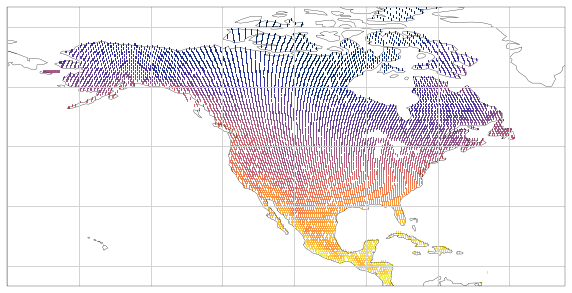

In [28]:
interact(temp_plot, period={'jan':0, 'aug':8, 'year':12})